In [171]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# 5章 顧客の退会を予測する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析する。  
３章では顧客の全体像を把握し、4章では数ヶ月利用している顧客の来月の利用回数の予測を行った。   
ここでは、教師あり学習の分類を用いて、顧客の退会予測を取り扱う。

- 利用データ
- use_log_months.csv
  - Ch.04で作成した利用履歴を年月・顧客ごとに集計したデータ
- customer_join.csv
  - Ch.03で作成した利用履歴を含んだ顧客データ

### Knock41: データを読み込んで利用データを整形する

In [143]:
# データの読み込み

customer = pd.read_csv("../support/5章/customer_join.csv")
uselog_months = pd.read_csv("../support/5章/use_log_months.csv")

In [144]:
# 読み込んだデータの確認

print(customer.shape)
display(customer)

(4192, 18)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.8333,5.0000,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.0833,5.0000,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.5833,5.0000,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.8333,4.5000,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.9167,4.0000,6,1,1,2019-04-30,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaN,CA1,0,オールタイム,10500,通常,8.0000,8.0000,8,8,0,2019-04-30,1
4188,HD246549,XXXXX,C01,F,2019-03-14,NaN,CA1,0,オールタイム,10500,通常,10.0000,10.0000,10,10,0,2019-04-30,1
4189,GD037007,XXXXX,C03,M,2019-03-14,NaN,CA1,0,ナイト,6000,通常,8.0000,8.0000,8,8,0,2019-04-30,1
4190,OA953150,XXXXX,C01,M,2019-03-14,NaN,CA1,0,オールタイム,10500,通常,11.0000,11.0000,11,11,0,2019-04-30,1


In [145]:
# 読み込んだデータの確認

print(uselog_months.shape)
display(uselog_months)

(36842, 3)


,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [146]:
# データの加工
# 「201805」以降のデータを抽出

year_months = list(uselog_months["年月"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"] == year_months[i]].copy()
    tmp_before = uselog_months.loc[uselog_months["年月"] == year_months[i-1]].copy()
    del tmp_before["年月"]
    tmp_before.rename(columns={"count": "count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True, axis=0)

display(uselog)

,年月,customer_id,count,count_1
0,201805,AS002855,5,4.0000
1,201805,AS009373,4,3.0000
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0000
4,201805,AS015739,5,7.0000
...,...,...,...,...
33846,201903,TS995853,8,11.0000
33847,201903,TS998593,8,7.0000
33848,201903,TS999079,3,2.0000
33849,201903,TS999231,6,6.0000


### Knock42: 退会前月の退会顧客データを作成する

- 退会前月のデータを作成する理由
  - 退会の予測をする目的は、退会を未然に防ぐこと
  - 「201809」に退会した顧客は、「201808」に退会申請をしている
  - 「201808」に退会申請をしている1ヶ月前の「201807」のデータから、退会申請を出す確率を予測する

In [147]:
# 退会した顧客を抽出する

exit_customer = customer.loc[customer["is_deleted"] == 1].copy()
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in exit_customer.index:
    exit_customer.loc[i, "exit_date"] = exit_customer.loc[i, "end_date"] - relativedelta(months=1)
exit_customer["exit_date"] = pd.to_datetime(exit_customer["exit_date"])
exit_customer["年月"] = exit_customer["exit_date"].dt.strftime("%Y%m")

uselog["年月"] = uselog["年月"].astype(str)
exit_uselog = pd.merge(
    uselog, exit_customer, 
    on=["customer_id", "年月"], 
    how="left"
)

print(uselog.shape)
display(exit_uselog)

(33851, 4)


,年月,customer_id,count,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,201805,AS009373,4,3.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,201805,AS015315,3,6.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,201805,AS015739,5,7.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33846,201903,TS995853,8,11.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
33847,201903,TS998593,8,7.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
33848,201903,TS999079,3,2.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
33849,201903,TS999231,6,6.0000,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [148]:
print(len(customer.loc[customer["is_deleted"] == 0]))
print(len(customer.loc[customer["is_deleted"] == 1]))
print(len(uselog_months["customer_id"].unique()))

2842
1350
4192


In [149]:
# 欠損値の除去
# 結合により欠損値が生じる理由
# -「uselog」データには、退会していない顧客が含まれている
# -「customer」データには、「201805」以前のデータが含まれている
# -「exit_customer」データにも、「201805」以前のデータが含まれている

exit_uselog = exit_uselog.dropna(subset=["name"])

print(len(exit_uselog["customer_id"].unique()))
print(exit_uselog.shape)
display(exit_uselog)

1104
(1104, 22)


,年月,customer_id,count,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0000,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,1.0000,オールタイム,10500.0000,通常,3.0000,3.0000,3.0000,3.0000,0.0000,2018-06-30,3.0000,2018-05-30
57,201805,AS169823,2,3.0000,XX,C01,M,2017-11-01,2018-06-30,CA1,1.0000,オールタイム,10500.0000,通常,3.0000,3.0000,4.0000,2.0000,1.0000,2018-06-30,7.0000,2018-05-30
110,201805,AS305860,5,3.0000,XXXX,C01,M,2017-06-01,2018-06-30,CA1,1.0000,オールタイム,10500.0000,通常,3.3333,3.0000,5.0000,2.0000,0.0000,2018-06-30,12.0000,2018-05-30
128,201805,AS363699,5,3.0000,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,1.0000,オールタイム,10500.0000,通常,3.3333,3.0000,5.0000,2.0000,0.0000,2018-06-30,4.0000,2018-05-30
147,201805,AS417696,1,4.0000,XX,C03,F,2017-09-01,2018-06-30,CA1,1.0000,ナイト,6000.0000,通常,2.0000,1.0000,4.0000,1.0000,0.0000,2018-06-30,9.0000,2018-05-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30758,201902,TS645212,4,2.0000,XXXX,C03,F,2018-03-01,2019-03-31,CA1,1.0000,ナイト,6000.0000,通常,4.5000,4.5000,7.0000,1.0000,0.0000,2019-03-31,12.0000,2019-02-28
30787,201902,TS741703,5,6.0000,XXXX,C03,M,2018-12-08,2019-03-31,CA3,1.0000,ナイト,6000.0000,入会費無料,6.2500,6.0000,8.0000,5.0000,0.0000,2019-03-31,3.0000,2019-02-28
30827,201902,TS859258,1,3.0000,XXXXX,C02,F,2018-12-07,2019-03-31,CA3,1.0000,デイタイム,7500.0000,入会費無料,2.5000,2.0000,5.0000,1.0000,0.0000,2019-03-31,3.0000,2019-02-28
30842,201902,TS886985,5,3.0000,XXX,C02,F,2018-03-01,2019-03-31,CA1,1.0000,デイタイム,7500.0000,通常,4.2500,4.0000,7.0000,2.0000,1.0000,2019-03-31,12.0000,2019-02-28


### Knock43: 継続顧客のデータを作成する

In [150]:
# 継続中の顧客を抽出する

conti_customer = customer.loc[customer["is_deleted"] == 0]
conti_uselog = pd.merge(
    uselog, conti_customer,
    on=["customer_id"],
    how="left"
)

print(len(conti_uselog))

33851


In [151]:
# 欠損値の確認

conti_uselog.isnull().sum()

年月                       0
customer_id              0
count                    0
count_1               1201
name                  6429
class                 6429
gender                6429
start_date            6429
end_date             33851
campaign_id           6429
is_deleted            6429
class_name            6429
price                 6429
campaign_name         6429
mean                  6429
median                6429
max                   6429
min                   6429
routine_flg           6429
calc_date             6429
membership_period     6429
dtype: int64

In [152]:
# 欠損値の削除

conti_uselog = conti_uselog.dropna(subset=["name"])
print(len(conti_uselog))

27422


- 「uselog」との結合は、"customer_id"のみで行っている
- 継続顧客データであるため、各年月ごとに"customer_id"がある（"customer_id"にダブりがある）
- 「exit_uselog」データとの均衡と取るため、「conti_uselog」データも顧客あたり1件になるようにする
- （アンダーサンプリング）

In [153]:
# データをシャッフルして、重複を除去する

# データをシャッフルする
conti_uselog = conti_uselog.sample(frac=1, random_state=0).reset_index(drop=True)
# "customer_id"が重複しているデータは、最初のデータのみを取得する
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")

print(conti_uselog.shape)
display(conti_uselog)

(2842, 21)


,年月,customer_id,count,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201806,AS015233,7,7.0000,XXXXX,C01,M,2018-05-13,NaN,CA2,0.0000,オールタイム,10500.0000,入会費半額,7.5455,7.0000,11.0000,4.0000,1.0000,2019-04-30,11.0000
1,201812,AS046594,7,5.0000,XXX,C01,M,2018-03-01,NaN,CA1,0.0000,オールタイム,10500.0000,通常,7.1667,7.0000,10.0000,5.0000,1.0000,2019-04-30,13.0000
2,201808,OA769163,6,4.0000,XXX,C01,M,2017-05-01,NaN,CA1,0.0000,オールタイム,10500.0000,通常,6.0833,6.0000,8.0000,2.0000,1.0000,2019-04-30,23.0000
3,201805,AS981537,10,6.0000,XX,C03,M,2018-02-01,NaN,CA1,0.0000,ナイト,6000.0000,通常,6.9167,7.0000,10.0000,5.0000,1.0000,2019-04-30,14.0000
4,201805,GD065188,6,7.0000,XX,C01,M,2017-09-01,NaN,CA1,0.0000,オールタイム,10500.0000,通常,6.3333,6.5000,9.0000,3.0000,1.0000,2019-04-30,19.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,201903,HI285716,12,NaN,XXXX,C01,M,2019-03-03,NaN,CA1,0.0000,オールタイム,10500.0000,通常,12.0000,12.0000,12.0000,12.0000,1.0000,2019-04-30,1.0000
26178,201903,OA245157,8,NaN,XXXXX,C01,M,2019-03-12,NaN,CA1,0.0000,オールタイム,10500.0000,通常,8.0000,8.0000,8.0000,8.0000,0.0000,2019-04-30,1.0000
26344,201902,HD516896,8,NaN,XXXXX,C01,F,2019-02-15,NaN,CA1,0.0000,オールタイム,10500.0000,通常,9.0000,9.0000,10.0000,8.0000,1.0000,2019-04-30,2.0000
26726,201903,TS306264,11,NaN,XXXXX,C03,M,2019-03-06,NaN,CA1,0.0000,ナイト,6000.0000,通常,11.0000,11.0000,11.0000,11.0000,1.0000,2019-04-30,1.0000


In [154]:
# 継続顧客データと退会顧客データの結合

predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True, axis=0)
print(conti_uselog.shape)
print(exit_uselog.shape)
print(predict_data.shape)
display(predict_data)

(2842, 21)
(1104, 22)
(3946, 22)


,年月,customer_id,count,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201806,AS015233,7,7.0000,XXXXX,C01,M,2018-05-13,NaT,CA2,0.0000,オールタイム,10500.0000,入会費半額,7.5455,7.0000,11.0000,4.0000,1.0000,2019-04-30,11.0000,NaT
1,201812,AS046594,7,5.0000,XXX,C01,M,2018-03-01,NaT,CA1,0.0000,オールタイム,10500.0000,通常,7.1667,7.0000,10.0000,5.0000,1.0000,2019-04-30,13.0000,NaT
2,201808,OA769163,6,4.0000,XXX,C01,M,2017-05-01,NaT,CA1,0.0000,オールタイム,10500.0000,通常,6.0833,6.0000,8.0000,2.0000,1.0000,2019-04-30,23.0000,NaT
3,201805,AS981537,10,6.0000,XX,C03,M,2018-02-01,NaT,CA1,0.0000,ナイト,6000.0000,通常,6.9167,7.0000,10.0000,5.0000,1.0000,2019-04-30,14.0000,NaT
4,201805,GD065188,6,7.0000,XX,C01,M,2017-09-01,NaT,CA1,0.0000,オールタイム,10500.0000,通常,6.3333,6.5000,9.0000,3.0000,1.0000,2019-04-30,19.0000,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,201902,TS645212,4,2.0000,XXXX,C03,F,2018-03-01,2019-03-31,CA1,1.0000,ナイト,6000.0000,通常,4.5000,4.5000,7.0000,1.0000,0.0000,2019-03-31,12.0000,2019-02-28
3942,201902,TS741703,5,6.0000,XXXX,C03,M,2018-12-08,2019-03-31,CA3,1.0000,ナイト,6000.0000,入会費無料,6.2500,6.0000,8.0000,5.0000,0.0000,2019-03-31,3.0000,2019-02-28
3943,201902,TS859258,1,3.0000,XXXXX,C02,F,2018-12-07,2019-03-31,CA3,1.0000,デイタイム,7500.0000,入会費無料,2.5000,2.0000,5.0000,1.0000,0.0000,2019-03-31,3.0000,2019-02-28
3944,201902,TS886985,5,3.0000,XXX,C02,F,2018-03-01,2019-03-31,CA1,1.0000,デイタイム,7500.0000,通常,4.2500,4.0000,7.0000,2.0000,1.0000,2019-03-31,12.0000,2019-02-28


### Knock44: 予測する月の在籍期間を作成する

In [155]:
# "period"（在籍期間）列を追加する

predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i, "now_date"], predict_data.loc[i, "start_date"])
    predict_data.loc[i, "period"] = int(delta.years*12 + delta.months)

display(predict_data)

,年月,customer_id,count,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201806,AS015233,7,7.0000,XXXXX,C01,M,2018-05-13,NaT,CA2,0.0000,オールタイム,10500.0000,入会費半額,7.5455,7.0000,11.0000,4.0000,1.0000,2019-04-30,11.0000,NaT,0,2018-06-01
1,201812,AS046594,7,5.0000,XXX,C01,M,2018-03-01,NaT,CA1,0.0000,オールタイム,10500.0000,通常,7.1667,7.0000,10.0000,5.0000,1.0000,2019-04-30,13.0000,NaT,9,2018-12-01
2,201808,OA769163,6,4.0000,XXX,C01,M,2017-05-01,NaT,CA1,0.0000,オールタイム,10500.0000,通常,6.0833,6.0000,8.0000,2.0000,1.0000,2019-04-30,23.0000,NaT,15,2018-08-01
3,201805,AS981537,10,6.0000,XX,C03,M,2018-02-01,NaT,CA1,0.0000,ナイト,6000.0000,通常,6.9167,7.0000,10.0000,5.0000,1.0000,2019-04-30,14.0000,NaT,3,2018-05-01
4,201805,GD065188,6,7.0000,XX,C01,M,2017-09-01,NaT,CA1,0.0000,オールタイム,10500.0000,通常,6.3333,6.5000,9.0000,3.0000,1.0000,2019-04-30,19.0000,NaT,8,2018-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,201902,TS645212,4,2.0000,XXXX,C03,F,2018-03-01,2019-03-31,CA1,1.0000,ナイト,6000.0000,通常,4.5000,4.5000,7.0000,1.0000,0.0000,2019-03-31,12.0000,2019-02-28,11,2019-02-01
3942,201902,TS741703,5,6.0000,XXXX,C03,M,2018-12-08,2019-03-31,CA3,1.0000,ナイト,6000.0000,入会費無料,6.2500,6.0000,8.0000,5.0000,0.0000,2019-03-31,3.0000,2019-02-28,1,2019-02-01
3943,201902,TS859258,1,3.0000,XXXXX,C02,F,2018-12-07,2019-03-31,CA3,1.0000,デイタイム,7500.0000,入会費無料,2.5000,2.0000,5.0000,1.0000,0.0000,2019-03-31,3.0000,2019-02-28,1,2019-02-01
3944,201902,TS886985,5,3.0000,XXX,C02,F,2018-03-01,2019-03-31,CA1,1.0000,デイタイム,7500.0000,通常,4.2500,4.0000,7.0000,2.0000,1.0000,2019-03-31,12.0000,2019-02-28,11,2019-02-01


### Knock45: 欠損値を除去する

In [156]:
# 欠損値の確認

predict_data.isna().sum()

年月                      0
customer_id             0
count                   0
count_1               255
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [157]:
# predict_data["count_1"]が欠損しているデータのみ除外する

predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

年月                      0
customer_id             0
count                   0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2639
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2639
period                  0
now_date                0
dtype: int64

### Knock46: 文字列型の変数を処理できるように整形する

- 説明変数
  - ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period"]
- 目的変数
  - ["is_deleted"]
- 教師あり学習の分類
  - 目的変数は離散値

In [158]:
# データの絞り込み

target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
display(predict_data)

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,入会費半額,オールタイム,M,7.0000,1.0000,0,0.0000
1,通常,オールタイム,M,5.0000,1.0000,9,0.0000
2,通常,オールタイム,M,4.0000,1.0000,15,0.0000
3,通常,ナイト,M,6.0000,1.0000,3,0.0000
4,通常,オールタイム,M,7.0000,1.0000,8,0.0000
...,...,...,...,...,...,...,...
3941,通常,ナイト,F,2.0000,0.0000,11,1.0000
3942,入会費無料,ナイト,M,6.0000,0.0000,1,1.0000
3943,入会費無料,デイタイム,F,3.0000,0.0000,1,1.0000
3944,通常,デイタイム,F,3.0000,1.0000,11,1.0000


In [159]:
# カテゴリカル変数をダミー変数化する

predict_data = pd.get_dummies(predict_data)
display(predict_data)

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,gender_F,gender_M
0,7.0000,1.0000,0,0.0000,1,0,0,1,0,0,0,1
1,5.0000,1.0000,9,0.0000,0,0,1,1,0,0,0,1
2,4.0000,1.0000,15,0.0000,0,0,1,1,0,0,0,1
3,6.0000,1.0000,3,0.0000,0,0,1,0,0,1,0,1
4,7.0000,1.0000,8,0.0000,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3941,2.0000,0.0000,11,1.0000,0,0,1,0,0,1,1,0
3942,6.0000,0.0000,1,1.0000,0,1,0,0,0,1,0,1
3943,3.0000,0.0000,1,1.0000,0,1,0,0,1,0,1,0
3944,3.0000,1.0000,11,1.0000,0,0,1,0,1,0,1,0


In [160]:
# 余分な列の削除

del predict_data["campaign_name_通常"]
del predict_data["class_name_ナイト"]
del predict_data["gender_M"]
display(predict_data)

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,7.0000,1.0000,0,0.0000,1,0,1,0,0
1,5.0000,1.0000,9,0.0000,0,0,1,0,0
2,4.0000,1.0000,15,0.0000,0,0,1,0,0
3,6.0000,1.0000,3,0.0000,0,0,0,0,0
4,7.0000,1.0000,8,0.0000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
3941,2.0000,0.0000,11,1.0000,0,0,0,0,1
3942,6.0000,0.0000,1,1.0000,0,1,0,0,0
3943,3.0000,0.0000,1,1.0000,0,1,0,1,1
3944,3.0000,1.0000,11,1.0000,0,0,0,1,1


### Knock47: 決定木を用いて退会予測モデルを作成する

- 決定木
  - 教師あり学習の分類アルゴリズム

In [165]:
exit = predict_data.loc[predict_data["is_deleted"] == 1]
conti = predict_data.loc[predict_data["is_deleted"] == 0].sample(len(exit), random_state=0)

X = pd.concat([exit, conti], ignore_index=True, axis=0)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print(y_test_pred)

[1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.

In [166]:
# 評価データの作成

results_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_test_pred
})
display(results_test)

,y_test,y_pred
1091,0.0000,1.0000
1786,0.0000,0.0000
1439,0.0000,0.0000
745,1.0000,1.0000
820,1.0000,0.0000
...,...,...
1029,1.0000,1.0000
553,1.0000,1.0000
1570,0.0000,0.0000
82,1.0000,1.0000


### Knock48: 予測モデルの評価を行い、モデルをチューニングする

In [167]:
# 正解率の計算

correct = len(results_test.loc[results_test["y_test"] == results_test["y_pred"]])
data_count = len(results_test)
score_test = correct / data_count
print(score_test)

0.8916349809885932


In [168]:
# 学習用データと評価用データの予測精度

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9759188846641318
0.8916349809885932


In [169]:
# モデルのチューニング

X = pd.concat([exit, conti], ignore_index=True, axis=0)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9252217997465145
0.9201520912547528


### Knock49: モデルに寄与している変数を確認する

In [170]:
# モデルに寄与している変数

importance = pd.DataFrame({
    "feature_names": X.columns,
    "coefficient": model.feature_importances_
})
display(importance)

,feature_names,coefficient
0,count_1,0.3640
1,routine_flg,0.1366
2,period,0.4879
3,campaign_name_入会費半額,0.0000
4,campaign_name_入会費無料,0.0068
5,class_name_オールタイム,0.0046
6,class_name_デイタイム,0.0001
7,gender_F,0.0000


[Text(0.5643939393939394, 0.9166666666666666, 'period <= 11.5\ngini = 0.5\nsamples = 1578\nvalue = [792, 786]'),
 Text(0.26515151515151514, 0.75, 'count_1 <= 5.5\ngini = 0.392\nsamples = 955\nvalue = [256, 699]'),
 Text(0.12121212121212122, 0.5833333333333334, 'count_1 <= 4.5\ngini = 0.083\nsamples = 600\nvalue = [26, 574]'),
 Text(0.06060606060606061, 0.4166666666666667, 'period <= 0.5\ngini = 0.016\nsamples = 496\nvalue = [4, 492]'),
 Text(0.030303030303030304, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.09090909090909091, 0.25, 'count_1 <= 3.5\ngini = 0.012\nsamples = 495\nvalue = [3, 492]'),
 Text(0.06060606060606061, 0.08333333333333333, 'gini = 0.0\nsamples = 359\nvalue = [0, 359]'),
 Text(0.12121212121212122, 0.08333333333333333, 'gini = 0.043\nsamples = 136\nvalue = [3, 133]'),
 Text(0.18181818181818182, 0.4166666666666667, 'routine_flg <= 0.5\ngini = 0.334\nsamples = 104\nvalue = [22, 82]'),
 Text(0.15151515151515152, 0.25, 'gini = 0.0\nsamples = 35\nvalue = [0, 

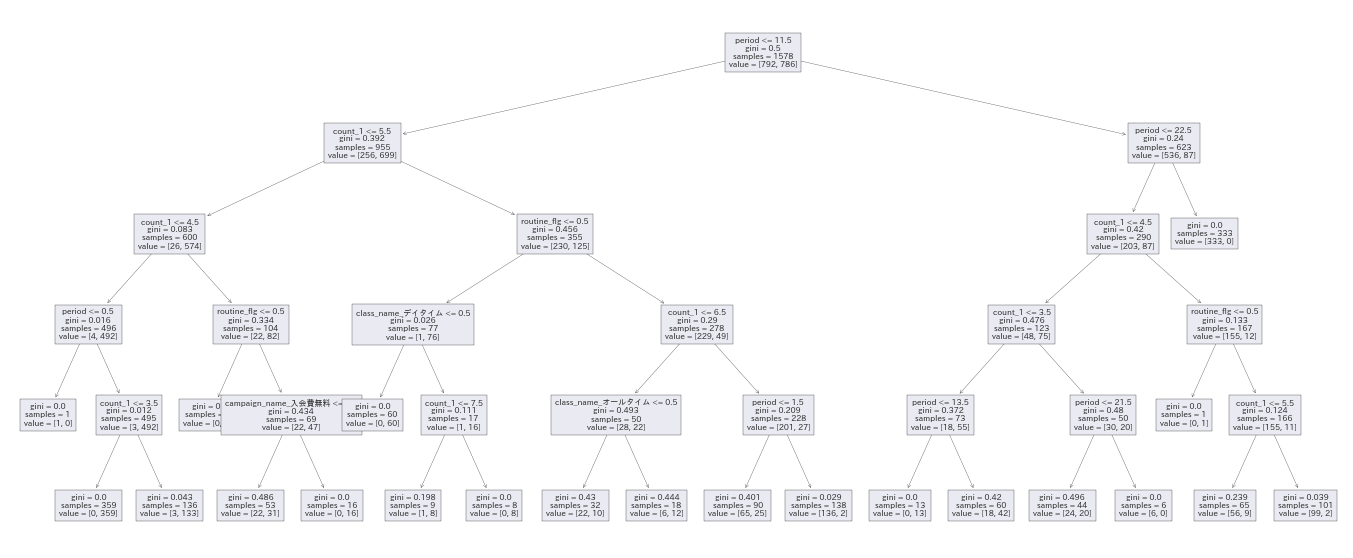

In [174]:
# モデルの可視化

plt.figure(figsize=(24, 10))
tree.plot_tree(model, feature_names=X.columns, fontsize=8)

### Knock50: 顧客の退会を予測する

In [175]:
# 新規データの作成

count_1 = 3
routine_flg = 1
period = 10
campaign_name = "入会費無料"
class_name = "オールタイム"
gender = "M"

In [176]:
# 新規データの加工

if campaign_name == "入会費半額":
    campaign_name_list = [1, 0]
elif campaign_name == "入会費無料":
    campaign_name_list = [0, 1]
elif campaign_name == "通常":
    campaign_name_list = [0, 0]

if class_name == "オールタイム":
    class_name_list = [1, 0]
elif class_name == "デイタイム":
    class_name_list = [0, 1]
elif class_name == "ナイトタイム":
    class_name_list = [0, 0]

if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]

input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)
input_data = pd.DataFrame(data=[input_data], columns=X.columns)
display(input_data)

,count_1,routine_flg,period,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,3,1,10,0,1,1,0,0


In [177]:
print(model.predict(input_data))
print(model.predict_proba(input_data))

[1.]
[[0. 1.]]
